In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import decision_infovalue
import importlib
importlib.reload(decision_infovalue)

<module 'decision_infovalue' from '/Users/guoziyang/Documents/Documents - GuoZiYang的MacBook Pro/info-value-toolkit/decision_infovalue/__init__.py'>

# Data Preparation

In [3]:
data, metadata = decision_infovalue.get_dataset("cxr")
data.head()

,Unnamed: 0,study_id,abnormal_stratified,diagnosis,densenet121_pred,inception_v3_pred,swin_b_pred,resnet50_pred,vit_b_16_pred
0,1,57962525,True,1.0,0.7,0.6,0.6,0.7,0.7
1,2,51877206,True,1.0,0.5,0.6,0.6,0.7,0.6
2,3,50285724,True,1.0,0.8,0.6,0.7,0.8,0.5
3,4,52515667,True,0.0,0.6,0.6,0.4,0.6,0.3
4,5,50340689,False,0.0,0.1,0.1,0.2,0.1,0.1


# Information Model

In [4]:
info_model = decision_infovalue.DecisionInfoModel(data, metadata["target_name"], 
                                     signals=["diagnosis","densenet121_pred","inception_v3_pred","swin_b_pred","resnet50_pred","vit_b_16_pred"], 
                                     scoring_rule="brier",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)

In [5]:
info_model.all_breaks

{'diagnosis': None,
 'densenet121_pred': array([0. , 0.1, 0.2, 0.4, 0.5, 1. ]),
 'inception_v3_pred': None,
 'swin_b_pred': array([0. , 0.1, 0.2, 0.3, 0.5, 0.9]),
 'resnet50_pred': None,
 'vit_b_16_pred': array([0. , 0.1, 0.2, 0.3, 0.5, 1. ])}

# Global human-complementary information value in each AI model

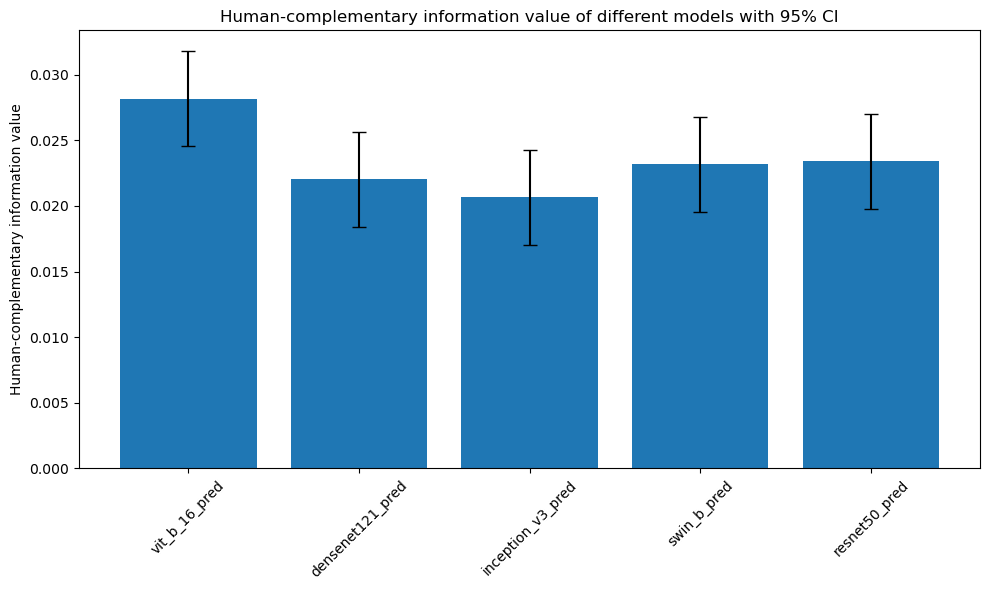

In [6]:
from scipy import stats

models = ["vit_b_16_pred", "densenet121_pred", "inception_v3_pred", "swin_b_pred", "resnet50_pred"]
values = []
stds = []

for model in models:
    value, std = info_model.complement_info_value(model, "diagnosis", True)
    values.append(value)
    stds.append(std)

ci_errors = np.array([[std * stats.t.ppf((1 + 0.95) / 2, len(data) - 1), std * stats.t.ppf((1 + 0.95) / 2, len(data) - 1)] for value, std in zip(values, stds)]).T

plt.figure(figsize=(10, 6))
plt.bar(models, values, yerr=ci_errors, capsize=5)
plt.xticks(rotation=45)
plt.ylabel('Human-complementary information value')
plt.title('Human-complementary information value of different models with 95% CI')
plt.tight_layout()
# info_model.complement_info_value("densenet121_pred", "diagnosis", 0.95)
# info_model.complement_info_value("inception_v3_pred", "diagnosis", 0.95)
# info_model.complement_info_value("swin_b_pred", "diagnosis", 0.95)
# info_model.complement_info_value("resnet50_pred", "diagnosis", 0.95)

# Robust analysis on a grid of V-shaped scoring rules

In [13]:
test_model = decision_infovalue.DecisionInfoModel(data, metadata["target_name"], 
                                     signals=["diagnosis","densenet121_pred","inception_v3_pred","swin_b_pred","resnet50_pred","vit_b_16_pred"], 
                                     scoring_rule="v_shaped_0.5",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)
test_model.complement_info_value("vit_b_16_pred", "diagnosis")
# test_model.complement_info_value("inception_v3_pred", "diagnosis")

0.038106141139913285

In [15]:
grid_size = 100
model_pair_diffs = np.zeros((len(models), len(models), grid_size))
model_pair_kinks = np.zeros((len(models), len(models), grid_size))
for model in models:
    for compare_model in models:
        model_pair_diffs[models.index(model), models.index(compare_model)], \
        model_pair_kinks[models.index(model), models.index(compare_model)] = \
            info_model.robust_analysis_on_v_shaped_scoring_rule(model, compare_model, 
                                                                base_signals=["diagnosis"], 
                                                                ret_diff=True, grid_size=grid_size)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/3h/9bh8gjqn3r99nq3frnmlnkhr0000gn/T/ipykernel_42923/1354549907.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0, hspace=0)


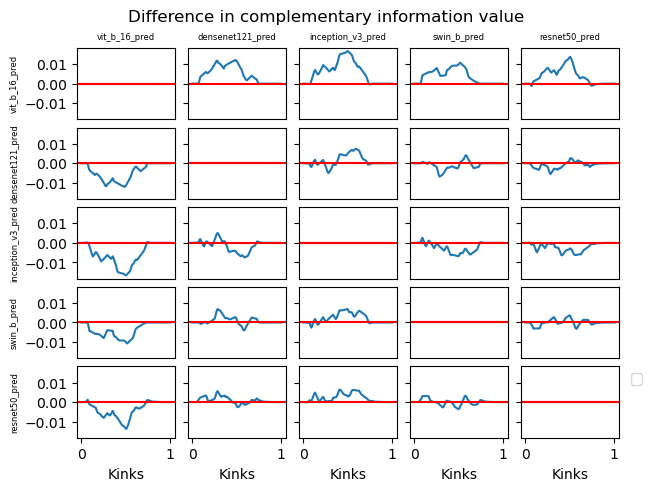

In [43]:

# plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(len(models), len(models), layout='constrained', sharey=True)

for i, model in enumerate(models):
    for j, compare_model in enumerate(models):
        axes[i, j].plot(model_pair_kinks[i,j], model_pair_diffs[i,j])
        axes[i, j].axhline(y=0, color='r', alpha=1)
        if i == len(models) - 1:
            axes[i, j].set_xlabel('Kinks')
        if i == 0:
            axes[i, j].set_title(f'{compare_model}', fontsize=6)
        if i != len(models) - 1:
            axes[i, j].set_xticks([])
        if j == 0:
            axes[i, j].set_ylabel(f'{model}', fontsize=6)

# plt.xlabel('Kink position')
# plt.ylabel('Difference in complementary information value')
plt.suptitle('Difference in complementary information value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0, hspace=0)